<a href="https://colab.research.google.com/github/sudhanshumukherjeexx/PyTorch-Playground/blob/main/4_MemoryTracking_Datasets_%26_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author**: [Sudhanshu Mukherjee](https://github.com/sudhanshumukherjeexx/PyTorch-Playground)

**Date**: 11-20-2024

**Topic**: PyTorch Playground: Memory Management, Custom Datasets, and Augmentations


## This notebook demonstrates advanced features in three main areas:

### 1. Memory Management: Learn how to efficiently handle GPU memory in PyTorch
### 2. Custom Datasets: Understand how to create datasets for different data types
### 3. Data Augmentation: Explore various techniques to augment your training data

---

### Function to handle libraries required

In [1]:
import subprocess
import sys

def check_and_install_libraries():
    """
    Checks if the required libraries are installed else installs missing ones.
    """
    # List of required libraries
    required_libraries = ["torch","torchvision","albumentations","augly","memory_profiler","pillow","numpy","pandas","matplotlib"]
    # Function to check and install a library
    def install_if_missing(lib):
        try:
            __import__(lib)
            print(f"{lib} is already installed.")
        except ImportError:
            print(f"{lib} is not installed. Installing now...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", lib])
    for library in required_libraries:
        lib_to_import = {
            "pillow": "PIL",  # pillow imports as PIL - special handling
        }.get(library, library)  # same name if no special case
        install_if_missing(lib_to_import)
    print("\n Requirements installed successfully!")

# Run the function
check_and_install_libraries()

torch is already installed.
torchvision is already installed.


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


albumentations is already installed.
augly is already installed.
memory_profiler is already installed.
PIL is already installed.
numpy is already installed.
pandas is already installed.
matplotlib is already installed.

 Requirements installed successfully!


- Import all necessary Libraries for implementing image processing, data handline, PyTorch etc

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torchvision
import albumentations as A
import augly.image as imaugs
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import os
import matplotlib.pyplot as plt
from memory_profiler import profile
import gc
from sklearn.datasets import fetch_california_housing
import requests
from io import BytesIO
import nltk
from nltk.corpus import gutenberg
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

### 0. Utility Functions
- These functions help in visualizing and preparing data throughout the tutorial.

In [3]:
def plot_images(images, titles=None, figsize=(15, 3)):
    """Helper function to plot images"""
    n = len(images)
    # Create figure
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]

    for i, (ax, img) in enumerate(zip(axes, images)):
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).cpu().numpy()
        # Display image
        ax.imshow(img)
        if titles:
            ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    return fig

In [4]:
def plot_dataset_samples(dataset_name, dataloader, class_names, figsize=(15, 4)):
    """
    Plot samples from a dataset with improved visualization
    """
    # Get a batch of images
    images, labels = next(iter(dataloader))

    # Create figure
    fig, axes = plt.subplots(1, 4, figsize=figsize)
    fig.suptitle(f'{dataset_name} Dataset Samples ({images.shape[-1]}x{images.shape[-2]} pixels)', fontsize=14)

    for idx, ax in enumerate(axes):
        # tensor to numpy - for viz
        img = images[idx].permute(1, 2, 0).numpy()

        # Denormalize
        img = np.clip(img, 0, 1)

        # Display image
        ax.imshow(img)
        ax.set_title(f'{class_names[labels[idx]]}\n{images.shape[-1]}x{images.shape[-2]} pixels')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## 🧠 1. Understanding Memory Management and Efficiency in PyTorch
- Understanding and efficiently managing GPU memory is crucial for deep learning.

- This section demonstrates various memory management techniques in PyTorch.

In [5]:
print("\nFirst, let's check our PyTorch setup:")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"GPU Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")


First, let's check our PyTorch setup:
PyTorch Version: 2.5.1+cu121
CUDA Available: True
GPU Device: Tesla T4


### 1.1 Basic Memory Tracking

- Allocated memory: Actually used memory
- Cached memory: Memory reserved by PyTorch but not currently in use

In [6]:
def check_memory():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**2
        cached = torch.cuda.memory_reserved() / 1024**2
        print(f"Allocated: {allocated:.2f}MB")
        print(f"Cached: {cached:.2f}MB")
    else:
        print("Running on CPU")

In [7]:
print("\nInitial memory state:")
check_memory()


Initial memory state:
Allocated: 0.00MB
Cached: 0.00MB


- Create a large tensor

In [8]:
print("\nCreating a large tensor...")
x = torch.randn(5000, 5000, device='cuda' if torch.cuda.is_available() else 'cpu')
print("After creating tensor:")
check_memory()


Creating a large tensor...
After creating tensor:
Allocated: 96.00MB
Cached: 96.00MB


- Clear memory

In [9]:
print("\nClearing memory...")
del x
torch.cuda.empty_cache() if torch.cuda.is_available() else None
gc.collect()
check_memory()


Clearing memory...
Allocated: 0.00MB
Cached: 0.00MB


### 1.2 Gradient Checkpointing

### Gradient checkpointing is essential for memory-efficient training

- Not storing all intermediate activations
- Recomputing them during backward pass

In [10]:
print("1.2 Gradient Checkpointing for Memory Efficiency")
class SimpleModel(nn.Module):
    def __init__(self, use_checkpointing=False):
        super().__init__()
        self.layers = nn.Sequential(*[nn.Linear(100, 100) for _ in range(10)])
        self.use_checkpointing = use_checkpointing

    def forward(self, x):
        if self.use_checkpointing:
            return torch.utils.checkpoint.checkpoint_sequential(self.layers, 3, x)
        return self.layers(x)

1.2 Gradient Checkpointing for Memory Efficiency


- Compare memory usage with and without checkpointing

In [11]:
input_data = torch.randn(1000, 100, device='cuda' if torch.cuda.is_available() else 'cpu')

# Without checkpointing
model_normal = SimpleModel(use_checkpointing=False)
if torch.cuda.is_available():
    model_normal = model_normal.cuda()
print("\nWithout checkpointing:")
check_memory()
output_normal = model_normal(input_data)
check_memory()


Without checkpointing:
Allocated: 0.77MB
Cached: 2.00MB
Allocated: 12.72MB
Cached: 26.00MB


In [12]:
# With checkpointing
model_checkpoint = SimpleModel(use_checkpointing=True)
if torch.cuda.is_available():
    model_checkpoint = model_checkpoint.cuda()
print("\nWith checkpointing:")
check_memory()
output_checkpoint = model_checkpoint(input_data)
check_memory()


With checkpointing:
Allocated: 13.11MB
Cached: 26.00MB
Allocated: 15.02MB
Cached: 30.00MB


### 1.3 Mixed Precision Training

### Implement mixed precision training using PyTorch's AMP (Automatic Mixed Precision).
    
- Benefits of mixed precision:
    - Reduced memory usage
    - Faster training
    - Lower memory bandwidth usage
    
- This is especially useful for:
    - Training large models
    - Working with high-resolution images
    - Maximizing GPU utilization

In [13]:
print("\n1.3 Mixed Precision Training")

def train_step(model, data, use_mixed_precision=False):
    if use_mixed_precision and torch.cuda.is_available():
        scaler = torch.cuda.amp.GradScaler()
        with torch.cuda.amp.autocast():
            output = model(data)
            loss = output.mean()
        scaler.scale(loss).backward()
    else:
        output = model(data)
        loss = output.mean()
        loss.backward()
    return loss


1.3 Mixed Precision Training


- Compare FP32 vs Mixed Precision

In [14]:
print("\nComparing FP32 vs Mixed Precision Training:")
model = SimpleModel()
if torch.cuda.is_available():
    model = model.cuda()


Comparing FP32 vs Mixed Precision Training:


In [15]:
print("\nFP32 Training:")
check_memory()
loss_fp32 = train_step(model, input_data, use_mixed_precision=False)
check_memory()


FP32 Training:
Allocated: 15.41MB
Cached: 30.00MB
Allocated: 23.92MB
Cached: 34.00MB


In [16]:
print("\nMixed Precision Training:")
check_memory()
loss_mixed = train_step(model, input_data, use_mixed_precision=True)
check_memory()


Mixed Precision Training:
Allocated: 23.92MB
Cached: 34.00MB
Allocated: 23.92MB
Cached: 34.00MB


---

## 📚 2. Working with Custom Datasets
PyTorch's Dataset class is a powerful tool for handling different types of data.
This section shows how to create custom datasets for various data types.

### 2.1 Image Dataset
- Download CIFAR-10

In [17]:
print("Loading CIFAR-10 Dataset (32x32 pixels)...")
cifar_transform = transforms.Compose([
    transforms.ToTensor()
])

cifar_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=cifar_transform
)

cifar_loader = DataLoader(
    cifar_dataset,
    batch_size=4,
    shuffle=True
)

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

Loading CIFAR-10 Dataset (32x32 pixels)...
Files already downloaded and verified


- Download STL10 (96x96)

In [18]:
print("\nLoading STL10 Dataset (96x96 pixels)...")
stl10_transform = transforms.Compose([
    transforms.ToTensor()
])

stl10_dataset = torchvision.datasets.STL10(
    root='./data',
    split='train',
    download=True,
    transform=stl10_transform
)

stl10_loader = DataLoader(
    stl10_dataset,
    batch_size=4,
    shuffle=True
)

stl10_classes = ['airplane', 'bird', 'car', 'cat', 'deer',
                 'dog', 'horse', 'monkey', 'ship', 'truck']


Loading STL10 Dataset (96x96 pixels)...
Files already downloaded and verified


- Display resolution comparison


Comparing dataset resolutions:

1. CIFAR-10 Samples (32x32 pixels):


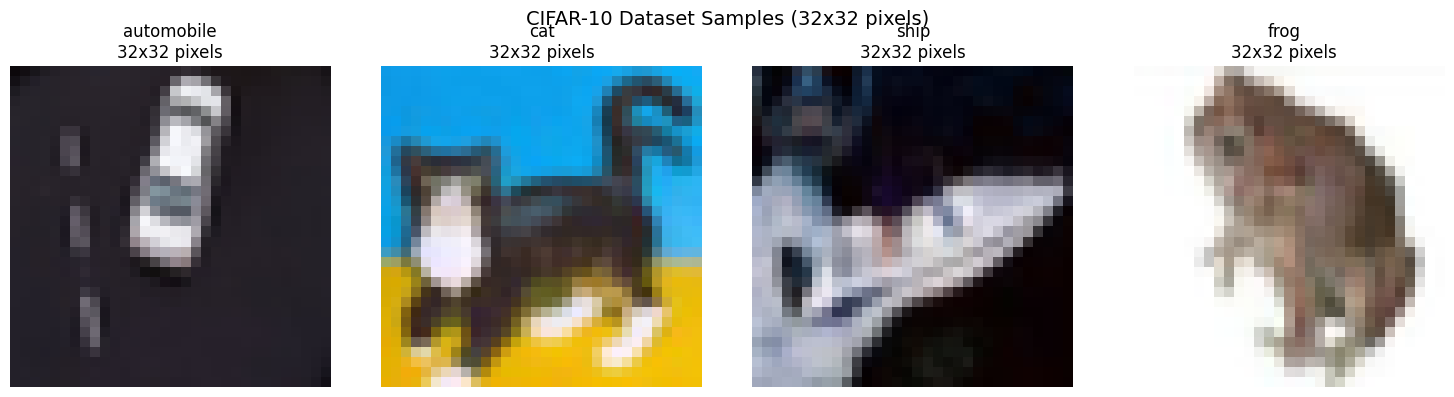


2. STL10 Samples (96x96 pixels):


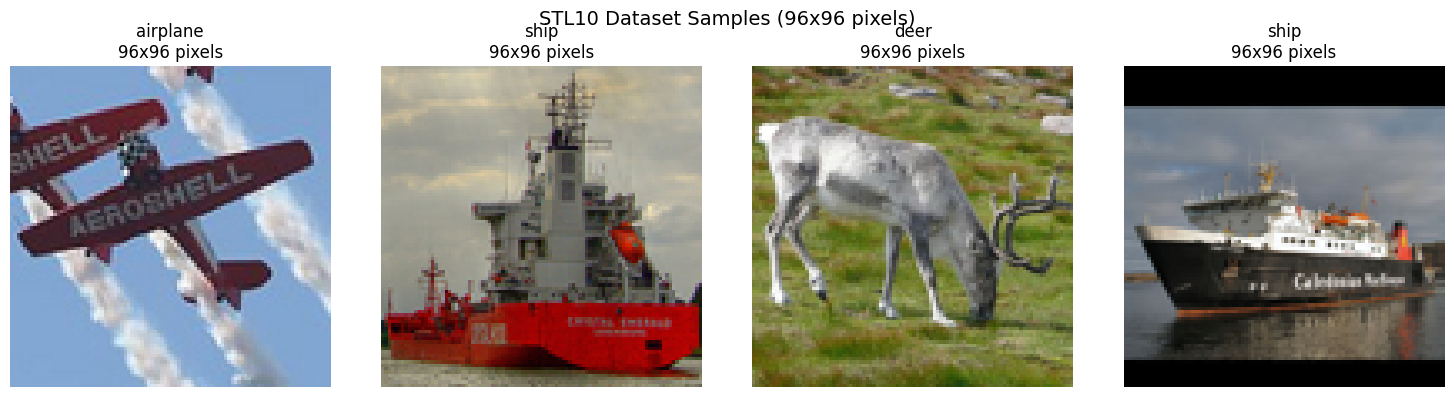

In [19]:
print("\nComparing dataset resolutions:\n")
print("1. CIFAR-10 Samples (32x32 pixels):")
plot_dataset_samples("CIFAR-10", cifar_loader, cifar_classes)

print("\n2. STL10 Samples (96x96 pixels):")
plot_dataset_samples("STL10", stl10_loader, stl10_classes)

In [20]:
cifar_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

print("Downloading CIFAR-10 dataset...")
cifar_dataset = datasets.CIFAR10(root='./data', train=True,
                                download=True, transform=cifar_transform)
cifar_loader = DataLoader(cifar_dataset, batch_size=4, shuffle=True)

Files already downloaded and verified


### 2.2 Text Dataset

- Download NLTK data

In [21]:
print("\n2.2 Custom Text Dataset with NLTK")
nltk.download('punkt_tab')
nltk.download('gutenberg')


2.2 Custom Text Dataset with NLTK


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [22]:
print("\nPreparing text dataset from Shakespeare's Hamlet...")
sentences = list(gutenberg.sents('shakespeare-hamlet.txt'))[:5]
print("\nSample sentences:")
for i, sent in enumerate(sentences, 1):
    print(f"{i}. {' '.join(sent)}")


Preparing text dataset from Shakespeare's Hamlet...

Sample sentences:
1. [ The Tragedie of Hamlet by William Shakespeare 1599 ]
2. Actus Primus .
3. Scoena Prima .
4. Enter Barnardo and Francisco two Centinels .
5. Barnardo .


### 2.3 Time Series Dataset
- Generate sample time series data

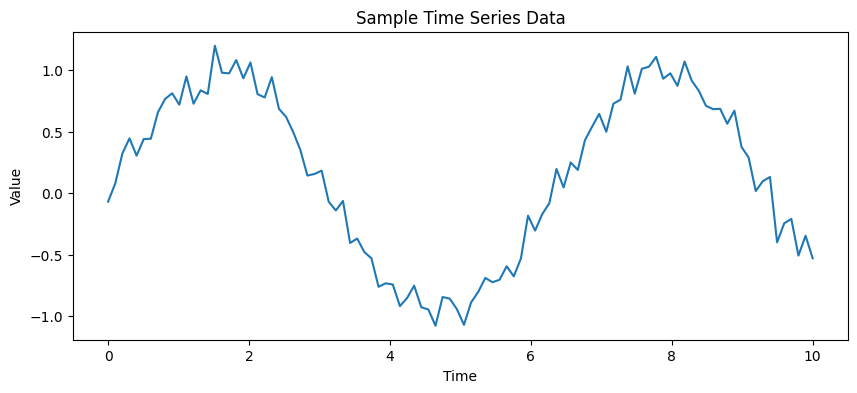

In [23]:
t = np.linspace(0, 10, 100)
time_series = np.sin(t) + np.random.normal(0, 0.1, len(t))

plt.figure(figsize=(10, 4))
plt.plot(t, time_series)
plt.title("Sample Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

---

## 🔄 3. Data Augmentation Techniques

### Data augmentation is crucial for improving model generalization.This section demonstrates three different augmentation libraries:
1. Torchvision: PyTorch's built-in augmentation
2. Albumentations: Advanced image augmentation
3. AugLy: Facebook's augmentation library

### 3.1 Torchivision Transforms
- Download sample images

In [24]:
def get_sample_image():
    url = "https://raw.githubusercontent.com/pytorch/pytorch.github.io/master/assets/images/pytorch-logo.png"
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    print(f'intial image mode: {image.mode}')
    if image.mode != 'RGB':
      image = image.convert('RGB')

    return image


print("\n3.1 Torchvision Transforms")
image = get_sample_image()
print(f'fetched image mode: {image.mode}')


3.1 Torchvision Transforms
intial image mode: P
fetched image mode: RGB


In [25]:
torch_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

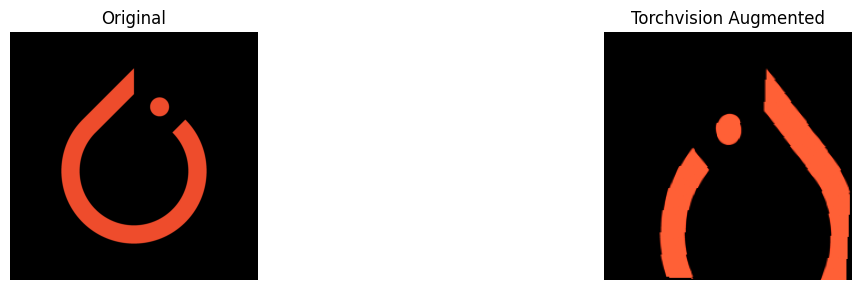

In [26]:
augmented_torch = torch_transforms(image)
plot_images([image, augmented_torch.permute(1, 2, 0).numpy()],
           ['Original', 'Torchvision Augmented'])
plt.show()

### 3.2 Albumentations


3.2 Albumentations


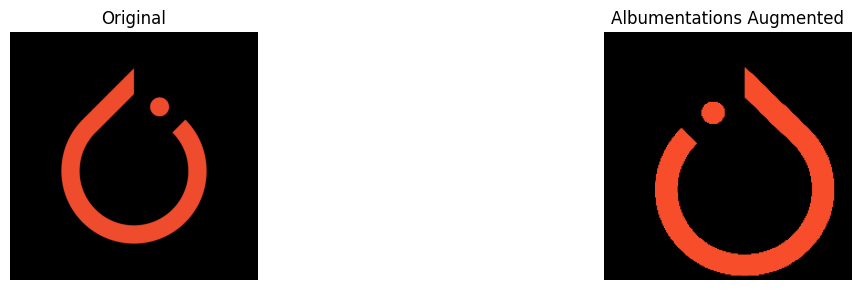

In [27]:
print("\n3.2 Albumentations")
alb_transforms = A.Compose([
    A.RandomResizedCrop(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.3),
])

augmented_alb = alb_transforms(image=np.array(image))['image']
plot_images([image, augmented_alb],
           ['Original', 'Albumentations Augmented'])
plt.show()

### 3.3 AugLy
- Apply Augly Tranformation Individually
- Apply Augly Transformation Combined

In [28]:
def augly_transforms_individually(image):
    """
    Test each AugLy transform separately to isolate any issues
    """
    results = []
    captions = ['Original']

    try:
        # Meme format
        print("Testing meme_format...")
        meme = imaugs.meme_format(
            image=image,
            caption_height=1000,
            text="PyTorch",
            meme_bg_color=(0, 0, 0),
            text_color=(255, 255, 255)
        )
        results.append(meme)
        captions.append('Meme Format')

        # Saturation
        print("Testing saturation...")
        sat_aug = imaugs.Saturation(factor=1.5)
        saturated = sat_aug(image)
        results.append(saturated)
        captions.append('Saturated')

        # Scale
        print("Testing scale...")
        scale_aug = imaugs.Scale(factor=0.9)
        scaled = scale_aug(image)
        results.append(scaled)
        captions.append('Scaled')

        # Simple rotation
        rotate_aug = imaugs.RandomRotation()
        rotate = rotate_aug(image)
        results.append(rotate)
        captions.append('Rotated')

    except Exception as e:
        print(f"Error in individual transform testing: {str(e)}")

    return results, captions

AugLy Transformation Individually
Testing meme_format...
Testing saturation...
Testing scale...


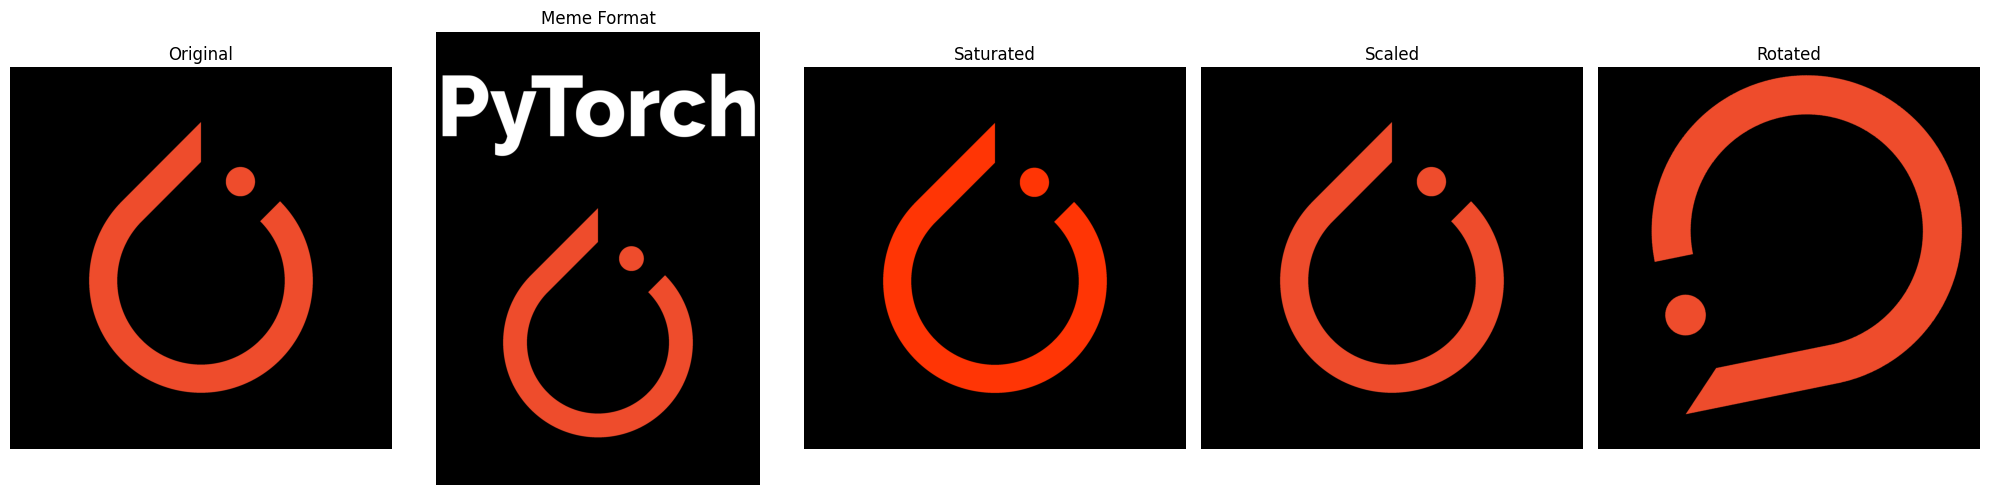

In [29]:
print("AugLy Transformation Individually")
augly_results, augly_captions = augly_transforms_individually(image)
plot_images(
            [image] + augly_results,
            augly_captions,
            figsize=(20, 5)
        )
plt.show()

- Augly Tranformation Combined

In [30]:
def augly_transforms_combined(image):
    """
    Apply AugLy transformation
    """
    try:
        meme = imaugs.meme_format(
            image=image,
            caption_height=500,
            text="PyTorch",
            meme_bg_color=(0, 0, 0),
            text_color=(255, 255, 255),
        )
        composed_aug = imaugs.Compose([
            imaugs.Saturation(factor=1.5),
            imaugs.Scale(factor=0.9),
            imaugs.RandomRotation()
        ])

        # Apply the composed transforms to the meme image
        final_image = composed_aug(meme)

        return final_image
    except Exception as e:
        print(f"Error in individual transform testing: {str(e)}")

AugLy Transformation Combined


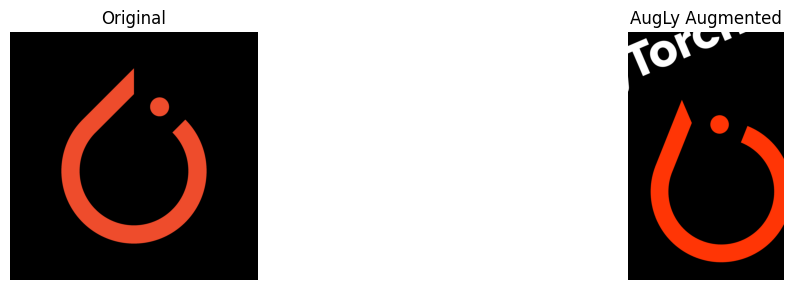

In [31]:
print("AugLy Transformation Combined")
augmented_augly = augly_transforms_combined(image)
plot_images([image, augmented_augly],
           ['Original', 'AugLy Augmented'])
plt.show()

## ⭐ Note
`As we progress through this notebook, we've evolved our implementation strategy to better reflect real-world best practices. Let's understand why this evolution matters.`

`In our earlier sections, we explored concepts through direct code execution. While this approach is excellent for learning and understanding individual concepts, it has limitations when building larger projects.`

`We're now transitioning to a more structured, function-based approach. This approach will help you not only understand the concepts but also learn how to implement them in a production-ready manner.`

## 🧠 Part 1: Memory Management

In [32]:
def memory_status():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f}MB")
        print(f"Cached: {torch.cuda.memory_reserved() / 1024**2:.2f}MB")

In [33]:
def demonstrate_memory_management():
    """
    Demonstrates basic memory management operations in PyTorch.

    This function shows:
    1. How to track memory usage
    2. Impact of creating large tensors
    3. How to properly clear GPU memory

    """

    print("\nInitial memory state:")
    memory_status()

    print("\nCreating large tensor...")
    x = torch.randn(5000, 5000, device='cuda' if torch.cuda.is_available() else 'cpu')
    print("After creating tensor:")
    memory_status()

    print("\nClearing memory...")
    del x
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    gc.collect()
    memory_status()

- Gradient Checkpointing

In [34]:
class ModelWithCheckpointing(nn.Module):
    """
    Demonstrates gradient checkpointing for memory-efficient training.

    Gradient checkpointing trades computation for memory by:
    - Not storing all intermediate activations
    - Recomputing them during backward pass

    This is particularly useful for:
    - Training very deep networks
    - Working with limited GPU memory
    - Handling large batch sizes
    """

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(*[nn.Linear(100, 100) for _ in range(10)])

    def forward(self, x):
        return torch.utils.checkpoint.checkpoint_sequential(
            self.layers, 3, x
        )

- Mixed Precision Training

In [35]:
def setup_mixed_precision():
    """
    Sets up mixed precision training using PyTorch's AMP (Automatic Mixed Precision).

    Benefits of mixed precision:
    - Reduced memory usage
    - Faster training
    - Lower memory bandwidth usage

    This is especially useful for:
    - Training large models
    - Working with high-resolution images
    - Maximizing GPU utilization
    """
    scaler = torch.cuda.amp.GradScaler()

    def training_step(model, optimizer, data, target):
        with torch.cuda.amp.autocast():
            output = model(data)
            loss = nn.functional.cross_entropy(output, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        return loss
    return training_step

## 📚 Part 2: Custom Datasets

- Custom Image Dataset

In [36]:
class CustomImageDataset(Dataset):
    """
    Custom dataset for handling image data.

    Features:
    - Loads images from a directory
    - Applies transformations on-the-fly
    - Supports multiple image formats

    Use cases:
    - Custom image datasets
    - Medical imaging
    - Satellite imagery
    """
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

- Custom Text Dataset

In [37]:
class CustomTextDataset(Dataset):
    """
    Custom dataset for handling text data.

    Features:
    - Handles text input with labels
    - Supports custom tokenization
    - Manages variable length sequences

    Use cases:
    - Natural Language Processing
    - Sentiment Analysis
    - Text Classification
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx])
        }

- Custom Time-Series Dataset

In [38]:
class TimeSeriesDataset(Dataset):
    """
    Custom dataset for handling time series data.

    Features:
    - Handles sequential data
    - Creates sliding windows
    - Supports multiple features

    Use cases:
    - Financial data analysis
    - Sensor data processing
    - Weather forecasting
    """
    def __init__(self, data, sequence_length):
        self.data = torch.FloatTensor(data)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return self.data[idx:idx + self.sequence_length]

## 🔄 Part 3: Data Augmentation

- Torchvision Transforms

In [39]:
def get_train_transforms():
    """
    Creates a composition of Torchvision transforms for training.

    Features:
    - Random cropping and flipping
    - Color jittering
    - Normalization

    Benefits:
    - Reduces overfitting
    - Improves model generalization
    - Increases effective dataset size
    """
    return transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

- Albumentations Transform Pipeline

In [40]:
def get_albumentation_transforms():
    """
    Creates an Albumentations transform pipeline.

    Features:
    - Advanced geometric transforms
    - Complex color augmentations
    - Blur and noise effects

    Benefits:
    - Faster than Torchvision
    - More augmentation options
    - Better control over augmentation probability
    """
    return A.Compose([
        A.RandomResizedCrop(height=224, width=224),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussNoise(p=0.3),
        A.OneOf([
            A.MotionBlur(blur_limit=5),
            A.MedianBlur(blur_limit=5),
            A.GaussianBlur(blur_limit=5),
        ], p=0.3),
    ])

In [41]:
def demonstrate_all_augmentations(image):
    """
    Demonstrate all types of augmentations
    """
    print("\nDemonstrating All Augmentations:")

    try:
        # 1. Torchvision
        print("\n1. Torchvision Transforms:")
        torchvision_aug = get_train_transforms()(image)

        # 2. Albumentations
        print("\n2. Albumentations Transforms:")
        alb_transforms = get_albumentation_transforms()
        albumentation_aug = alb_transforms(image=np.array(image))['image']

        # 3. AugLy Individual
        print("\n3. AugLy Individual Transforms:")
        augly_results, augly_captions = augly_transforms_individually(image)

        # 4. AugLy Combined
        print("\n4. AugLy Combined Transforms:")
        augly_combined = augly_transforms_combined(image)

        # Plot all results
        print("\nPlotting results...")

        # Plot Torchvision and Albumentations
        plot_images(
            [image, torchvision_aug, Image.fromarray(albumentation_aug)],
            ['Original', 'Torchvision', 'Albumentations'],
            figsize=(15, 5)
        )
        plt.show()

        # Plot AugLy individual transforms
        print("\nAugly Individual Transformation Results")
        plot_images(
            [image] + augly_results,
            augly_captions,
            figsize=(20, 5)
        )
        plt.show()

        # Plot AugLy combined
        print("\nAugly Combined Transformation Results")
        plot_images(
            [image, augly_combined],
            ['Original', 'AugLy Combined'],
            figsize=(10, 5)
        )
        plt.show()

    except Exception as e:
        print(f"Error in augmentation demonstration: {str(e)}")

##💡How do we call these functions in our main function? Let's check that out!

Starting Sample Datasets...

1. Testing Memory Management...

Initial memory state:
Allocated: 23.92MB
Cached: 34.00MB

Creating large tensor...
After creating tensor:
Allocated: 119.92MB
Cached: 130.00MB

Clearing memory...
Allocated: 23.92MB
Cached: 30.00MB

2. Testing Datasets...

Loading CIFAR-10 Dataset...
Files already downloaded and verified
CIFAR-10 dataset size: 50000
CIFAR-10 batch shape: torch.Size([32, 3, 224, 224])

Preparing Text Dataset...
Text dataset size: 1000

Preparing Time Series Dataset...
Time series dataset size: 950

3. Testing Augmentations...
intial image mode: P

Demonstrating All Augmentations:

1. Torchvision Transforms:

2. Albumentations Transforms:

3. AugLy Individual Transforms:
Testing meme_format...
Testing saturation...
Testing scale...

4. AugLy Combined Transforms:



Plotting results...


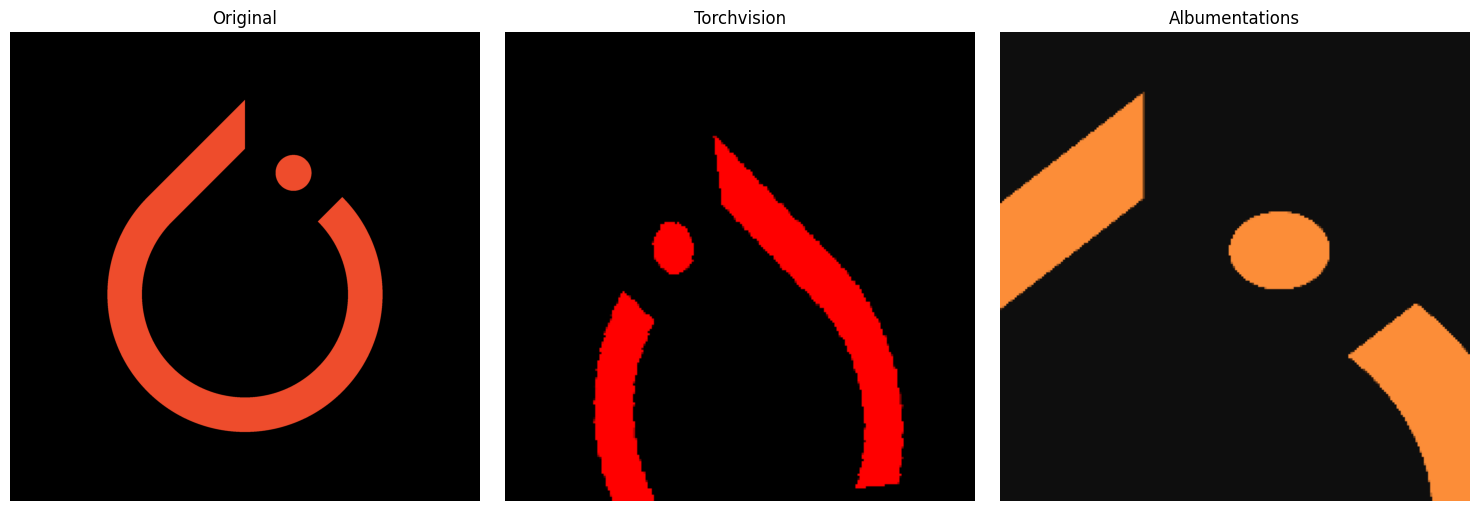


Augly Individual Transformation Results


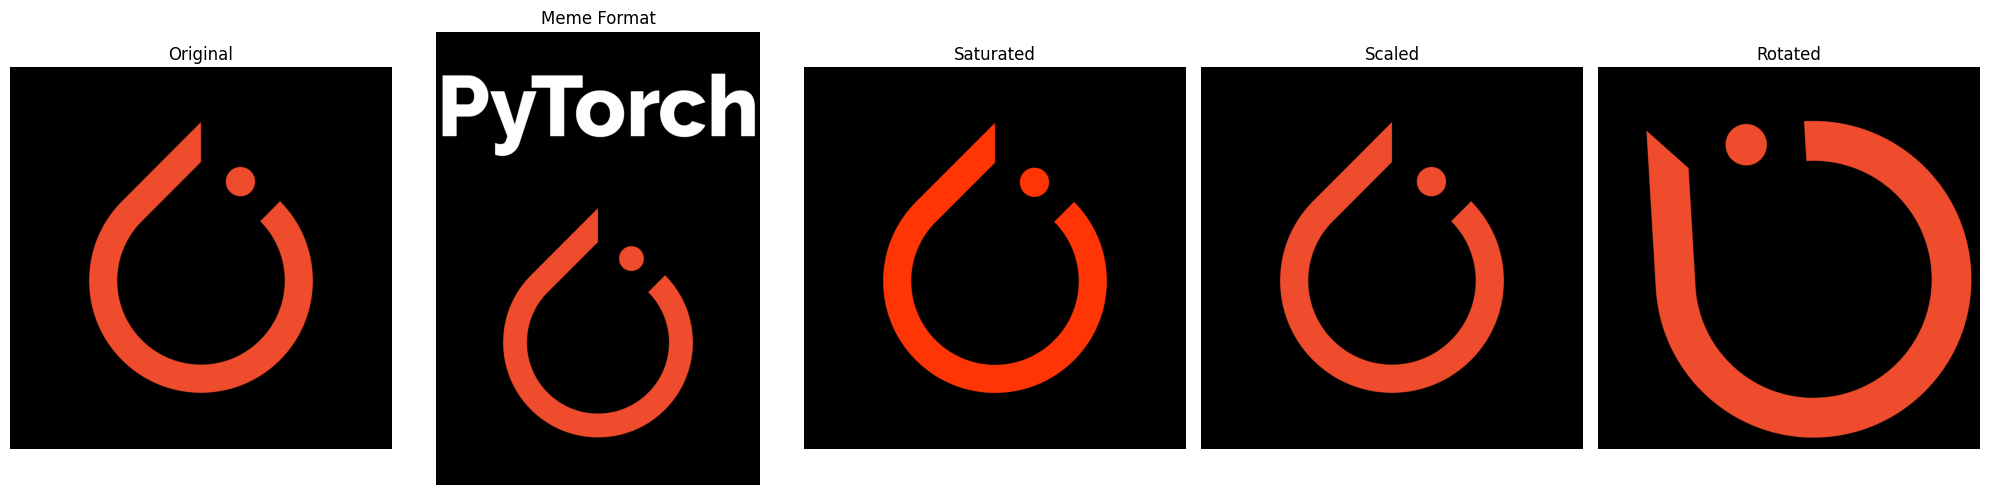


Augly Combined Transformation Results


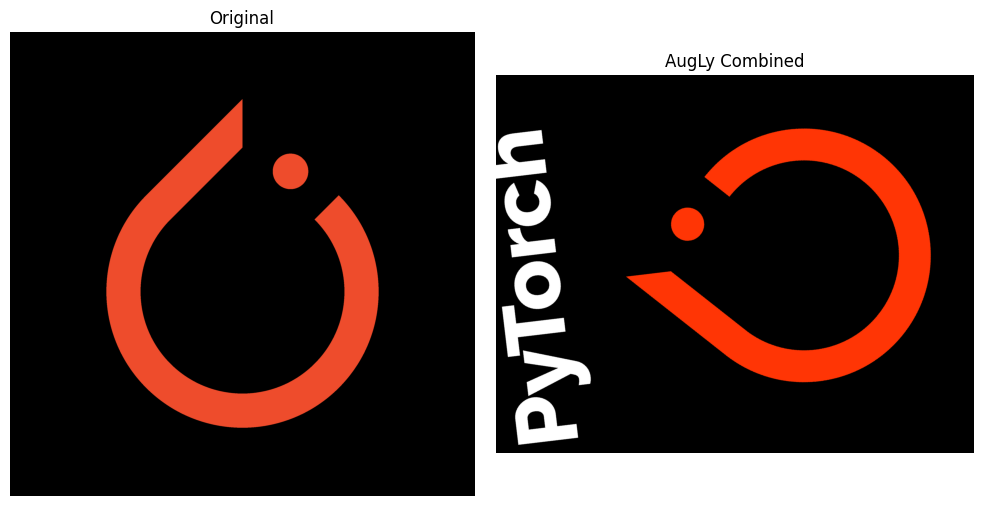


4. Testing Memory Efficient Training...
Training step completed with loss: 4.6455
\Implimentation completed successfully!


In [42]:
def main():
    print("Starting Sample Datasets...")

    # 1. Memory Management Demo
    print("\n1. Testing Memory Management...")
    demonstrate_memory_management()

    # 2. Dataset Creation
    print("\n2. Testing Datasets...")

    # Image Dataset using CIFAR-10
    print("\nLoading CIFAR-10 Dataset...")
    cifar_transform = get_train_transforms()
    cifar_dataset = datasets.CIFAR10(root='./data', train=True,
                                    download=True, transform=cifar_transform)
    cifar_loader = DataLoader(cifar_dataset, batch_size=32,
                            num_workers=2, pin_memory=True)

    # Show length and first batch
    print(f"CIFAR-10 dataset size: {len(cifar_dataset)}")
    images, labels = next(iter(cifar_loader))
    print(f"CIFAR-10 batch shape: {images.shape}")

    # Text Dataset using NLTK
    print("\nPreparing Text Dataset...")
    nltk.download('punkt_tab', quiet=True)
    nltk.download('gutenberg', quiet=True)
    from nltk.corpus import gutenberg

    # Get sample sentences from Gutenberg corpus
    sentences = list(gutenberg.sents('shakespeare-hamlet.txt'))[:1000]
    labels = [len(sent) % 2 for sent in sentences]  # Dummy labels

    # Simple tokenizer for demo
    class SimpleTokenizer:
        def __call__(self, text):
            return {
                'input_ids': torch.tensor([len(word_tokenize(str(text)))]),
                'attention_mask': torch.tensor([1])
            }

    text_dataset = CustomTextDataset(
        texts=sentences,
        labels=labels,
        tokenizer=SimpleTokenizer()
    )
    text_loader = DataLoader(text_dataset, batch_size=16, shuffle=True)
    print(f"Text dataset size: {len(text_dataset)}")

    # Time Series Dataset using sine wave
    print("\nPreparing Time Series Dataset...")
    t = np.linspace(0, 100, 1000)
    time_series_data = np.sin(t) + np.random.normal(0, 0.1, len(t))
    ts_dataset = TimeSeriesDataset(time_series_data, sequence_length=50)
    ts_loader = DataLoader(ts_dataset, batch_size=16, shuffle=True)
    print(f"Time series dataset size: {len(ts_dataset)}")

    # 3. Testing Augmentations
    print("\n3. Testing Augmentations...")

    # Download sample image for augmentation demo
    original_image = get_sample_image()
    demonstrate_all_augmentations(original_image)


    # 4. Memory Efficiency Demo with Model
    print("\n4. Testing Memory Efficient Training...")

    # Create small model with checkpointing
    model = ModelWithCheckpointing()
    if torch.cuda.is_available():
        model = model.cuda()

    # Test mixed precision setup
    training_step = setup_mixed_precision()
    optimizer = torch.optim.Adam(model.parameters())

    # Generate dummy data for training demo
    dummy_data = torch.randn(16, 100)
    dummy_target = torch.randint(0, 2, (16,))
    if torch.cuda.is_available():
        dummy_data = dummy_data.cuda()
        dummy_target = dummy_target.cuda()

    # Run one training step
    loss = training_step(model, optimizer, dummy_data, dummy_target)
    print(f"Training step completed with loss: {loss.item():.4f}")

    print("\Implimentation completed successfully!")


if __name__ == "__main__":
    results = main()